# <center> **Prequerities**</center>

In [11]:
#installations
!pip install finta
!pip install torch-summary

In [12]:
# packages import
# Numpy
import numpy as np

# Pandas
import pandas as pd 

# Pytorch
import torch
import torch.nn as nn
from torch import Tensor
from torchsummary import summary

# Seaborn
import seaborn as sns

# Finta
from finta import TA

# Optuna
import optuna
import torch.optim as optim

# Others
import matplotlib.pyplot as plt
import time
import os
import math
import copy
import sklearn.preprocessing as pp

In [13]:
# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [14]:
# font configuration
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 16}

plt.rc('font', **font)

# <center>**Data Preparation**</center>

In [15]:
# load the data
data = pd.read_csv("../input/btcusdt/okex_btcusdt_kline_1m.csv")
columns_dict = {'t': 'Unix_timestamp',
                'o': 'Opening_price',
                'h': 'Highest_price',
                'l': 'Lowest_price',
                'c': 'Closing_price',
                'v': 'Volume_of_transactions'
               }
data = data.rename(columns=columns_dict)

In [16]:
# show info of data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 488160 entries, 0 to 488159
Data columns (total 6 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Unix_timestamp          488160 non-null  int64  
 1   Opening_price           488160 non-null  float64
 2   Highest_price           488160 non-null  float64
 3   Lowest_price            488160 non-null  float64
 4   Closing_price           488160 non-null  float64
 5   Volume_of_transactions  488160 non-null  float64
dtypes: float64(5), int64(1)
memory usage: 22.3 MB


In [17]:
# plot data processing statistics
plot_data_process = True

In [18]:
# sort datapoints by timestamp
data = data.sort_values('Unix_timestamp', ignore_index=True)

In [19]:
# converts format from unix to UTC+8
data['Unix_timestamp'] = pd.to_datetime(data['Unix_timestamp'], unit='ms') + pd.Timedelta('08:00:00')
data = data.rename(columns={'Unix_timestamp': 'Timestamp'})

In [20]:
# add finta features
def add_finta_feature(data, data_finta ,feature_names, both_columns_features):
    """Adds new fanta features to data by their feature_name in feature_names

    Args:
        data: DataFrame, where the feature will be added
        data_finta: DataFrame, columns' names are: 'open', 'high', 'low', 'close' and 'volume'(optinal)
                    from which the new feature will be calculated
        feature_names: list of strings, names of the new features you want to add
        both_columns_features: list of strings, names of the new features you want to add both of their outputs
    """
    for feature_name in feature_names:
        feature_func = getattr(TA, feature_name)
        finta_feature = feature_func(data_finta) 
        if finta_feature.ndim > 1:
            if feature_name in both_columns_features:
                data["{}_1".format(feature_name)] = finta_feature.iloc[:, 0]
                data["{}_2".format(feature_name)] = finta_feature.iloc[:, 1]
            else:
                data[feature_name] = finta_feature.iloc[:, 0]
        else:
            data[feature_name] = finta_feature
        
# Finta needs specific columns' names to work
data_finta = pd.DataFrame()
data_finta['open'] = data['Opening_price']
data_finta['high'] = data['Highest_price']
data_finta['low'] = data['Lowest_price']
data_finta['close'] = data['Closing_price']
data_finta['volume'] = data['Volume_of_transactions']

# create data with all wanted features per minute
data_min = data.copy()
extra_features = ['TRIX', 'VWAP', 'MACD', 'EV_MACD', 'MOM', 'RSI', 'IFT_RSI', 'TR', 'ATR', 'BBWIDTH', 'DMI', 'ADX', 'STOCHRSI',
                  'MI', 'CHAIKIN', 'VZO', 'PZO', 'EFI', 'EBBP', 'BASP', 'BASPN', 'WTO', 'SQZMI', 'VFI', 'STC']
both_columns_features = ["DMI", "EBBP", "BASP", "BASPN"]
add_finta_feature(data_min, data_finta, extra_features, both_columns_features)

In [21]:
# find the maximum index containing NaN
if plot_data_process:
    print("Last index containing NaN in each feature:")
max_index = -np.inf
for column in data_min.columns:
    nan_indices = data_min[column].index[data_min[column].apply(np.isnan)]
    max_index_column = np.max(nan_indices)
    if plot_data_process:
        print("\t", column, ":", max_index_column)
    if max_index_column > max_index:
        max_index = max_index_column
if plot_data_process:
    print("\nLast index containing NaN in all data:", max_index)

Last index containing NaN in each feature:
	 Timestamp : nan
	 Opening_price : nan
	 Highest_price : nan
	 Lowest_price : nan
	 Closing_price : nan
	 Volume_of_transactions : nan
	 TRIX : 0
	 VWAP : nan
	 MACD : nan
	 EV_MACD : nan
	 MOM : 9
	 RSI : 0
	 IFT_RSI : 8
	 TR : nan
	 ATR : 12
	 BBWIDTH : 18
	 DMI_1 : 12
	 DMI_2 : 12
	 ADX : 12
	 STOCHRSI : 13
	 MI : 23
	 CHAIKIN : 7
	 VZO : nan
	 PZO : nan
	 EFI : 0
	 EBBP_1 : nan
	 EBBP_2 : nan
	 BASP_1 : nan
	 BASP_2 : nan
	 BASPN_1 : nan
	 BASPN_2 : nan
	 WTO : 0
	 SQZMI : nan
	 VFI : 130
	 STC : 12

Last index containing NaN in all data: 130


In [22]:
# drop the rows up to the last Nans in data of minutes - 131 minutes
start_index = max_index + 1
data_min = data_min.iloc[start_index: , :]
data_min = data_min.reset_index(drop=True)
start_hour = start_index // 60
start_minute = start_index % 60
# Drop Non-numeric columns
data_min.drop(['Timestamp'], inplace=True, axis=1)

# reorder columns by importance:
new_columns_order = ['Closing_price', 'Volume_of_transactions', 'Opening_price', 'Highest_price', 'Lowest_price','TRIX', 'VWAP', 'MACD',
                     'EV_MACD', 'MOM', 'RSI', 'IFT_RSI', 'TR', 'ATR', 'BBWIDTH', 'DMI_1', 'DMI_2', 'ADX', 'STOCHRSI', 'MI', 'CHAIKIN', 
                     'VZO', 'PZO', 'EFI', 'EBBP_1', 'EBBP_2', 'BASP_1', 'BASP_2', 'BASPN_1', 'BASPN_2', 'WTO', 'SQZMI', 'VFI', 'STC']
data_min = data_min[new_columns_order]
# show info of data - now there are no Nans
if plot_data_process:
    data_min.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 488029 entries, 0 to 488028
Data columns (total 34 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Closing_price           488029 non-null  float64
 1   Volume_of_transactions  488029 non-null  float64
 2   Opening_price           488029 non-null  float64
 3   Highest_price           488029 non-null  float64
 4   Lowest_price            488029 non-null  float64
 5   TRIX                    488029 non-null  float64
 6   VWAP                    488029 non-null  float64
 7   MACD                    488029 non-null  float64
 8   EV_MACD                 488029 non-null  float64
 9   MOM                     488029 non-null  float64
 10  RSI                     488029 non-null  float64
 11  IFT_RSI                 488029 non-null  float64
 12  TR                      488029 non-null  float64
 13  ATR                     488029 non-null  float64
 14  BBWIDTH             

# <center>**Model and Functions Definition**</center>

In [23]:
# split the data to train, validation and test
def train_validation_test_split(data, val_percentage, test_percentage):
    """Splits the data into train, validation and test

    Args:
        data: Tensor, shape [N, E]
        val_percentage: float, validation percentage from the data [0,1]
        test_percentage: float, test percentage from the data (0,1]
    Returns:
        train: Tensor, shape [N - N * (val_percentage + test_percentage), E]
        val: Tensor, shape [N * val_percentage, E] or None if val_percentage = 0
        test: Tensor, shape [N * test_percentage, E]
    """
    data_length = len(data)
    
    val_length = int(data_length * val_percentage)
    test_length = int(data_length * test_percentage)
    train_length = data_length - val_length - test_length
    
    train = data[:train_length]
    if val_length == 0:
        val = None
    else:
        val = data[train_length:train_length+val_length]
    test = data[train_length+val_length:]

    return train, val, test

In [24]:
def normalize_data(train, val ,test ,scaler=pp.StandardScaler()):
    """Scale the data: train, val and test according to train

    Args:
        train: Tensor, shape [N_train, E]
        val: Tensor, shape [N_val, E] (supports val=None)
        test: Tensor, shape [N_test, E]
        scaler: function, scaling function
    Returns:
        train: Tensor, shape [N_train, E]
        val: Tensor, shape [N_val, E]
        test: Tensor, shape [N_test, E]
        fitted_scaler: function, scaler fitted to train
    """
    fitted_scaler = scaler.fit(train)
    train = torch.tensor(fitted_scaler.transform(train))
    if val is not None:
        val = torch.tensor(fitted_scaler.transform(val))

    test = torch.tensor(fitted_scaler.transform(test))

    return train, val, test, fitted_scaler

In [25]:
def betchify(data, batch_size):
    """Divides the data into batch_size separate sequences, 
    removing extra elements that wouldn't cleanly fit.

    Args:
        data: Tensor, shape [N, E]
        batch_size: int, batch size

    Returns:
        Tensor of shape [N // batch_size, batch_size, E]
    """
    seq_len = data.size(0) // batch_size
    data = data[:seq_len * batch_size,:]
    data = data.view(batch_size, seq_len, -1)
    data = torch.transpose(data,0,1).contiguous()
    return data.to(device)

In [26]:
def get_batch(data, i, bptt_src, bptt_tgt, overlap):
    """Divides data to source and target, from offset i
    
    Args:
        source: Tensor, shape [N, batch_size, E]
        i: int, offset for the source
        bptt_src: int, size of back propagation through time, sequence length of source
        bptt_tgt: int, size of back propagation through time, sequence length of target
        overlap: int, number of overlapping elements between source and target

    Returns:
        source: Tensor, shape [bptt_src, batch_size, E]
        target: Tensor, shape [bptt_tgt, batch_size, E]
    """
    src_seq_len = min(bptt_src, len(data) - i - 1)
    target_seq_len = min(bptt_tgt, len(data) - i - src_seq_len + overlap)
    source = data[i: i + src_seq_len]
    target = data[i + src_seq_len - overlap: i + src_seq_len + target_seq_len - overlap]
    return source, target

In [27]:
class SineActivation(nn.Module):
    def __init__(self, in_features, periodic_features, out_features, dropout):
        super(SineActivation, self).__init__()
        # weights and biases for the periodic features
        self.w0 = nn.parameter.Parameter(torch.randn(in_features, out_features - in_features - periodic_features))
        self.b0 = nn.parameter.Parameter(torch.randn(1, out_features - in_features - periodic_features))
        # weights and biases for the linear features
        self.w = nn.parameter.Parameter(torch.randn(in_features, periodic_features))
        self.b = nn.parameter.Parameter(torch.randn(1, periodic_features))
        self.activation = torch.sin
        self.dropout = nn.Dropout(dropout)
        
    def Time2Vector(self, data):
        """Add features to data: 
            1. keep the original features numbered by - in_features
            2. add more periodic features numbered by - periodic_features
            3. add more linear feature to end up with total of features numbered by - out_features
    
        Args:
            data: Tensor, shape [N, batch_size, in_features]

        Returns:
            data: Tensor, shape [N, batch_size, out_features]
        """
        v_linear = torch.matmul(self.w0.t(), data.transpose(1,2)).transpose(1,2) + self.b0
        v_sin = self.activation(torch.matmul(self.w.t(), data.transpose(1,2)).transpose(1,2) + self.b)
        data = torch.cat([v_linear, v_sin, data], 2)
        return data

    def forward(self, data):
        data = self.Time2Vector(data)
        data = self.dropout(data)
        return data

In [28]:
class BTC_Transformer(nn.Module):
    def __init__(self,
                 num_encoder_layers: int,
                 num_decoder_layers: int,
                 in_features: int,
                 periodic_features: int,
                 out_features: int,
                 nhead: int,
                 dim_feedforward: int = 512,
                 dropout: float = 0.1,
                 activation: str = 'relu'):
        super(BTC_Transformer, self).__init__()
        
        self.sine_activation = SineActivation(in_features=in_features,
                                              periodic_features=periodic_features,
                                              out_features=out_features,
                                              dropout=dropout)
        
        self.transformer = nn.Transformer(d_model=out_features,
                                          nhead=nhead,
                                          num_encoder_layers=num_encoder_layers,
                                          num_decoder_layers=num_decoder_layers,
                                          dim_feedforward=dim_feedforward,
                                          dropout=dropout,
                                          activation=activation)
        
        self.generator = nn.Linear(out_features, in_features)
    
    def encode(self, src: Tensor, src_mask: Tensor):
        return self.transformer.encoder(self.sine_activation(src), src_mask)

    def decode(self, tgt: Tensor, memory: Tensor, tgt_mask: Tensor):
        return self.transformer.decoder(self.sine_activation(tgt), memory, tgt_mask)

    def forward(self,
                src: Tensor,
                trg: Tensor,
                src_mask: Tensor=None,
                tgt_mask: Tensor=None,
                mem_mask: Tensor=None,
                src_padding_mask: Tensor=None,
                tgt_padding_mask: Tensor=None,
                memory_key_padding_mask: Tensor=None):
        
        src_emb = self.sine_activation(src)
        tgt_emb = self.sine_activation(trg)
        outs = self.transformer(src_emb, tgt_emb, src_mask, tgt_mask, mem_mask,
                                src_padding_mask, tgt_padding_mask, memory_key_padding_mask)
        return self.generator(outs)

In [29]:
def evaluate(model, data, bptt_src, bptt_tgt, overlap, criterion, predicted_feature):
    """run the data through the model in eval mode and calculate the average loss in the given feature
    
    Args:
        model: nn.Module, the model you want to run the data in
        data: Tensor, shape [N, batch_size, E]
        bptt_src: int, size of back propagation through time, sequence length of source
        bptt_tgt: int, size of back propagation through time, sequence length of target
        overlap: int, number of overlapping elements between source and target
        criterion: nn.module, the loss function
        predicted_feature: int, index of the feature you want to evaluate in [0,E-1]
        

    Returns:
        mean_loss: float, average loss recieved over all data on the chosen feature
    """
    model.eval()     # Turn on the evaluation mode
    total_loss = 0.
    src_mask = torch.zeros((bptt_src,bptt_src), dtype=torch.bool).to(device) # zeros mask for the source (no mask)
    tgt_mask = model.transformer.generate_square_subsequent_mask(bptt_tgt).to(device) # look-ahead mask for the target
    with torch.no_grad():
        for i in range(0, data.size(0) - 1, bptt_src):
            source, targets = get_batch(data, i, bptt_src, bptt_tgt, overlap)
            src_batch_size = source.size(0)
            tgt_batch_size = targets.size(0)
            if tgt_batch_size != bptt_tgt or src_batch_size != bptt_src:  # only on last batch
                src_mask = src_mask[:src_batch_size, :src_batch_size]
                tgt_mask = tgt_mask[:tgt_batch_size, :tgt_batch_size]       
            output = model(source, targets, src_mask, tgt_mask)
            loss = criterion(output[:-1,:,predicted_feature], targets[1:,:,predicted_feature])
            total_loss += len(source) * loss.item()
    mean_loss = total_loss / (len(data) - 1)
    return mean_loss

# <center>**Data Separation to train-test-validation**</center>

In [30]:
# split the data
val_percentage = 0.1
test_percentage = 0.1
train_df, val_df, test_df = train_validation_test_split(data_min, val_percentage, test_percentage)
print(np.shape(train_df))
if val_df is not None:
    print(np.shape(val_df))
print(np.shape(test_df))

(390425, 34)
(48802, 34)
(48802, 34)


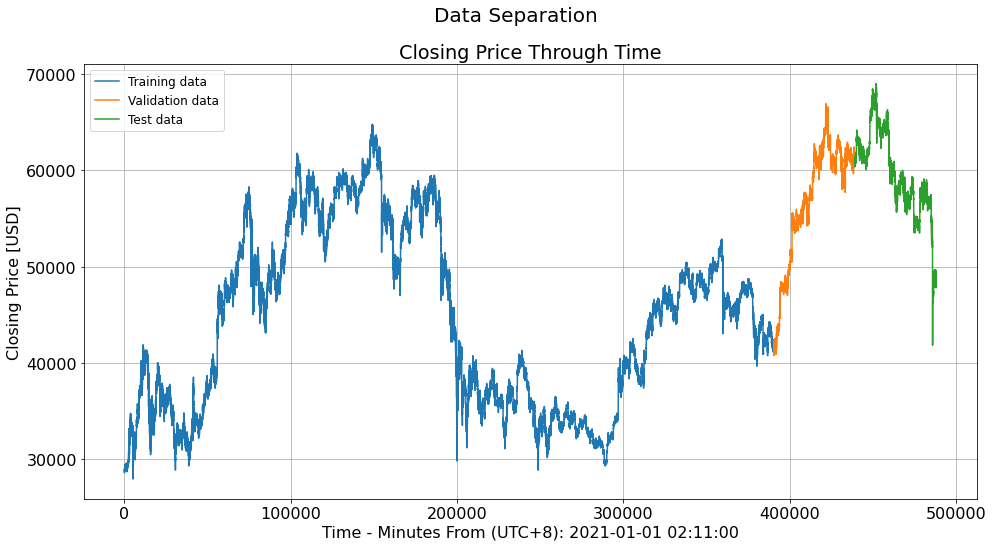

In [31]:
# plot train, validation and test separation
if plot_data_process:
    train_time = np.arange(np.size(train_df, 0))
    if val_df is not None:
        val_time = np.arange(np.size(train_df, 0), np.size(train_df, 0) + np.size(val_df, 0))
        test_time = np.arange(np.size(train_df, 0) + np.size(val_df, 0), np.size(train_df, 0) + np.size(val_df, 0) + np.size(test_df, 0))
    else:
        test_time = np.arange(np.size(train_df, 0), np.size(train_df, 0) + np.size(test_df, 0))
    fig = plt.figure(figsize=(16, 8))
    st = fig.suptitle("Data Separation", fontsize=20)
    ax = fig.add_subplot(1, 1 ,1)
    ax.set_xlabel("Time - Minutes From (UTC+8): 2021-01-01 {:02d}:{:02d}:00".format(start_hour, start_minute))     
    ax.set_ylabel("Closing Price [USD]")            
    ax.set_title("Closing Price Through Time")
    ax.plot(train_time, train_df['Closing_price'], label='Training data')
    if val_df is not None:
        ax.plot(val_time, val_df['Closing_price'], label='Validation data')
    ax.plot(test_time, test_df['Closing_price'], label='Test data')
    ax.grid()
    ax.legend(loc="best", fontsize=12) 
    plt.show()

# <center>**Optuna hyper-parameter optimization**</center>

In [32]:
# declaration of the define_model class for optuna
def define_model(trial):
    num_encoder_layers = trial.suggest_int("encoder_layers", 4, 8, step=4)
    num_decoder_layers = num_encoder_layers
    in_features = 34
    out_features = trial.suggest_int("out_features", 36, 64, step=4)
    nhead = int(out_features / 4)
    dim_feedforward = trial.suggest_int("dim_feedforward", 128, 512, step=128)
    dropout = trial.suggest_float("dropout", 0.0, 0.3, step=0.1)
    activation =  trial.suggest_categorical("activation", ["relu", "gelu"])
    periodic_features = int((((out_features - in_features) // 10) * 4) + 2)
    
    return BTC_Transformer(
                            num_encoder_layers=num_encoder_layers,
                            num_decoder_layers=num_decoder_layers,
                            in_features=in_features,
                            periodic_features=periodic_features,
                            out_features=out_features,
                            nhead=nhead,
                            dim_feedforward=dim_feedforward,
                            dropout=dropout,
                            activation=activation
        
                            ).to(device), in_features

In [33]:
# declaration of the objective class for optuna
def objective(trial):
    # split the data
    val_percentage = 0.1
    test_percentage = 0.1
    train_, val_, test_ = train_validation_test_split(data_min, val_percentage, test_percentage)

    # define the parameters
    overlap = 1
    criterion = nn.MSELoss()
    best_val_loss = float('inf')
    best_model = None
    in_features = 34
    num_features = in_features
    step_size = 1.0

    epochs = 50 
       
    train_batch_size = 32 
    eval_batch_size = 32 
    
    bptt_src = trial.suggest_int("bptt_src", 10, 60, step=10)
    bptt_tgt = trial.suggest_int("bptt_tgt", 2, 18, step=2)
    
    lr = 0.5 
    optimizer_name = "SGD" 
    
    scaler_name = trial.suggest_categorical("scaler_name", ["standard", "minmax"])
    
    gamma = 0.95 
    
    clip_param = trial.suggest_float("clip_param", 0.25, 1, step=0.25)
    
    random_start_point = trial.suggest_categorical("random_start_point", ["True", "False"])
    
    # define the model
    model, in_features = define_model(trial)
    num_features = in_features
    
    # define the optimizer
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)
    
    # define the scheduler
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size, gamma=gamma)
    
    # define the scaler
    if scaler_name == 'standard':
        scaler = pp.StandardScaler()
    if scaler_name == 'minmax':
        scaler = pp.MinMaxScaler()
        
    # create the relevant data
    train = train_df.iloc[:, :num_features]
    if val_df is not None:
        val = val_df.iloc[:, :num_features]
    else:
        val = val_df
    test = test_df.iloc[:, :num_features]
    train, val ,test ,scaler = normalize_data(train, val ,test ,scaler)
    train_data = betchify(train, train_batch_size).float()
    if val is not None:
        val_data = betchify(val, eval_batch_size).float()
    test_data = betchify(test, eval_batch_size).float()
    
    for epoch in range(1, epochs + 1):
        # epoch initialization
        model.train()
        total_loss = 0.
        epoch_loss = 0.

        # start point of the data
        if random_start_point:
            start_point = np.random.randint(bptt_src)
        else:
            start_point = 0

        num_batches = (len(train_data) - start_point) // bptt_src
        log_interval = round(num_batches // 3 / 10) * 10

        # masks for the model 
        src_mask = torch.zeros((bptt_src,bptt_src), dtype=torch.bool).to(device) # zeros mask for the source (no mask)
        tgt_mask = model.transformer.generate_square_subsequent_mask(bptt_tgt).to(device) # look-ahead mask for the target


        for batch, i in enumerate(range(start_point, train_data.size(0) - 1, bptt_src)):
            # forward
            source, targets = get_batch(train_data, i, bptt_src, bptt_tgt, overlap)
            src_batch_size = source.size(0)
            tgt_batch_size = targets.size(0)
            if tgt_batch_size != bptt_tgt or src_batch_size != bptt_src:  # only on last batch
                src_mask = src_mask[:src_batch_size, :src_batch_size]
                tgt_mask = tgt_mask[:tgt_batch_size, :tgt_batch_size]
            output = model(source, targets, src_mask, tgt_mask)
            loss = criterion(output[:-1,:,predicted_feature], targets[1:,:,predicted_feature])

            # backward
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_param)

            # step
            optimizer.step()

            # record bacth statistics
            total_loss += loss.item()
            epoch_loss += len(source) * loss.item()

            # print statistics every log_interval
            if (batch % log_interval == 0) and batch > 0:
                lr = scheduler.get_last_lr()[0]
                cur_loss = total_loss / log_interval
                total_loss = 0

        # evaluate on validation and save best model
        if val is not None:
            val_loss = evaluate(model, val_data, bptt_src, bptt_tgt, overlap, criterion, predicted_feature)
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model = copy.deepcopy(model)
            
            # report results of optuna trial
            trial.report(val_loss, epoch)  

            # cut trial if we get bad results
            if trial.should_prune():
                raise optuna.exceptions.TrialPruned()

        # scheduler step
        scheduler.step()

    if val is None:
        best_model = copy.deepcopy(model)

    return val_loss

In [34]:
predicted_feature = train_df.columns.get_loc('Closing_price')

sampler = optuna.samplers.TPESampler()
study = optuna.create_study(study_name="BTC_Transformer", direction="minimize", sampler=sampler)
study.optimize(objective, n_trials=50)

pruned_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED]
complete_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]

print("Study statistics: ")
print("Number of finished trials: ",len(study.trials))
print("Number of pruned trials: ", len(pruned_trials))
print("Number of complete trials: ", len(complete_trials))
print("Best trial: ")
trial = study.best_trial

print("Value: ", trial.value)
print("Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2022-01-19 21:54:49,238] A new study created in memory with name: BTC_Transformer
[I 2022-01-19 22:04:23,700] Trial 0 finished with value: 0.007927335495327226 and parameters: {'bptt_src': 50, 'bptt_tgt': 10, 'scaler_name': 'standard', 'clip_param': 1.0, 'random_start_point': 'True', 'encoder_layers': 8, 'out_features': 36, 'dim_feedforward': 256, 'dropout': 0.1, 'activation': 'gelu'}. Best is trial 0 with value: 0.007927335495327226.
[I 2022-01-19 22:27:37,913] Trial 1 finished with value: 6.288481720460743e-05 and parameters: {'bptt_src': 10, 'bptt_tgt': 4, 'scaler_name': 'minmax', 'clip_param': 0.75, 'random_start_point': 'False', 'encoder_layers': 4, 'out_features': 52, 'dim_feedforward': 256, 'dropout': 0.0, 'activation': 'gelu'}. Best is trial 1 with value: 6.288481720460743e-05.
[I 2022-01-19 22:32:45,305] Trial 2 finished with value: 0.002030373174969713 and parameters: {'bptt_src': 50, 'bptt_tgt': 10, 'scaler_name': 'minmax', 'clip_param': 0.75, 'random_start_point': 'False

Study statistics: 
Number of finished trials:  50
Number of pruned trials:  34
Number of complete trials:  16
Best trial: 
Value:  3.294229421299715e-05
Params: 
    bptt_src: 10
    bptt_tgt: 6
    scaler_name: minmax
    clip_param: 0.75
    random_start_point: False
    encoder_layers: 4
    out_features: 60
    dim_feedforward: 384
    dropout: 0.0
    activation: gelu


# <center>**Visualization**</center>

In [ ]:
# check which parameter is the most effective
optuna.visualization.plot_param_importances(study)

In [ ]:
# Visualizing the Search Space
optuna.visualization.plot_contour(study, params=["encoder_layers", "out_features"])

In [ ]:
# Visualizing the Search Space
optuna.visualization.plot_contour(study, params=["out_features", "dim_feedforward"])

In [ ]:
# Visualizing the Search Space
optuna.visualization.plot_contour(study, params=["dim_feedforward", "dropout"])

In [ ]:
# Visualizing the Search Space
optuna.visualization.plot_contour(study, params=["dropout", "activation"])

In [ ]:
# Visualizing the Search Space
optuna.visualization.plot_contour(study, params=["activation", "bptt_src"])

In [ ]:
# Visualizing the Search Space
optuna.visualization.plot_contour(study, params=["bptt_src", "bptt_tgt"])

In [ ]:
# Visualizing the Search Space
optuna.visualization.plot_contour(study, params=["bptt_tgt", "clip_param"])